In [1]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)
%matplotlib inline

In [2]:
# generate dataset
def synthetic_data(n_per_class=200, spread=0.8):
    centers = np.array([
        [0,0],
        [3,0],
        [0,3],
        [3,3],
        [1.5, 1.5]
    ])
    X_list, Y_list = [], []
    for i, c in enumerate(centers):
        Xc = c + spread * np.random.randn(n_per_class, 2)
        yc = np.full((n_per_class,), i, dtype=int)
        X_list.append(Xc)
        Y_list.append(yc)
    X = np.vstack(X_list)
    Y = np.concatenate(Y_list)
    return X, Y

X, Y = synthetic_data(n_per_class=300, spread=0.8)
print("X shape:", X.shape, "Y shape:", Y.shape)


perm = np.random.permutation(X.shape[0])
X, Y = X[perm], Y[perm]
# shuffle and split
split = int(0.8 * X.shape[0])
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])


X shape: (1500, 2) Y shape: (1500,)
Train samples: 1200 Test samples: 300


In [3]:
def one_hot(y, n_classes):
    oh = np.zeros((y.shape[0], n_classes))
    oh[np.arange(y.shape[0]), y] = 1
    return oh

def softmax(z):
      # numerically stable
    z = z - np.max(z, axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def cross_entropy_loss(y_true_onehot, y_pred_prob):
     # average cross-entropy
    eps = 1e-12
    y_pred_prob = np.clip(y_pred_prob, eps, 1.0 - eps)
    return -np.mean(np.sum(y_true_onehot * np.log(y_pred_prob), axis=1))


In [4]:
# NeuralNetwork class with 3 hidden layers
class NeuralNetwork:
    def __init__(self, input_dim, h1, h2, h3, output_dim, lr=0.1, seed=0):
        np.random.seed(seed)
        self.lr = lr
        # Glorot initialization
        def glorot(in_dim, out_dim):
            limit = np.sqrt(6.0 / (in_dim + out_dim))
            return np.random.uniform(-limit, limit, size=(in_dim, out_dim))

        self.W1 = glorot(input_dim, h1)
        self.b1 = np.zeros((1, h1))
        self.W2 = glorot(h1, h2)
        self.b2 = np.zeros((1, h2))
        self.W3 = glorot(h2, h3)
        self.b3 = np.zeros((1, h3))
        self.W4 = glorot(h3, output_dim)
        self.b4 = np.zeros((1, output_dim))

    # Activation: ReLU and its derivative
    def relu(self, x):
        return np.maximum(0, x)
    def relu_der(self, x):
        return (x > 0).astype(float)

    def forward(self, X):
        # Layer 1
        self.Z1 = X.dot(self.W1) + self.b1   # pre-activation
        self.A1 = self.relu(self.Z1)         # post-activation

        # Layer 2
        self.Z2 = self.A1.dot(self.W2) + self.b2
        self.A2 = self.relu(self.Z2)

        # Layer 3
        self.Z3 = self.A2.dot(self.W3) + self.b3
        self.A3 = self.relu(self.Z3)

        # Output layer
        self.Z4 = self.A3.dot(self.W4) + self.b4
        self.A4 = softmax(self.Z4)  # shape: (n_samples, output_dim)

        return self.A4

    def backward(self, X, Y_onehot, Y_pred):
        # Cross-entropy derivative wrt logits for softmax + CE simplifies to (y_pred - y_true)
        m = X.shape[0]
        dZ4 = (Y_pred - Y_onehot) / m  # shape (m, output_dim)

        # Gradients for W4, b4
        dW4 = self.A3.T.dot(dZ4)
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        # backprop into layer3
        dA3 = dZ4.dot(self.W4.T)
        dZ3 = dA3 * self.relu_der(self.Z3)
        dW3 = self.A2.T.dot(dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # layer2
        dA2 = dZ3.dot(self.W3.T)
        dZ2 = dA2 * self.relu_der(self.Z2)
        dW2 = self.A1.T.dot(dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # layer1
        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * self.relu_der(self.Z1)
        dW1 = X.T.dot(dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # update weights (gradient descent)
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train_epoch(self, X, Y_onehot):
        # forward + backward for full batch
        y_pred = self.forward(X)
        loss = cross_entropy_loss(Y_onehot, y_pred)
        self.backward(X, Y_onehot, y_pred)
        return loss


In [18]:

input_dim = X_train.shape[1]
n_classes = 5
nn = NeuralNetwork(input_dim=input_dim, h1=64, h2=64, h3=32, output_dim=n_classes, lr=0.1, seed=1)

Y_train_oh = one_hot(Y_train, n_classes)
Y_test_oh = one_hot(Y_test, n_classes)

epochs = 1000
loss_history = []
train_acc_history = []
test_acc_history = []

for epoch in range(1, epochs+1):
    loss = nn.train_epoch(X_train, Y_train_oh)
    loss_history.append(loss)

    if epoch % 100 == 0 or epoch == 1:
       # compute accuracies
        train_pred = nn.forward(X_train)
        train_labels = np.argmax(train_pred, axis=1)
        train_acc = np.mean(train_labels == Y_train)

        test_pred = nn.forward(X_test)
        test_labels = np.argmax(test_pred, axis=1)
        test_acc = np.mean(test_labels == Y_test)

        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
        print(f"Epoch {epoch:1d}: loss={loss:.2f}, train_acc={train_acc:.2f}, test_acc={test_acc:.2f}")


Epoch 1: loss=1.61, train_acc=0.40, test_acc=0.42
Epoch 100: loss=0.45, train_acc=0.84, test_acc=0.82
Epoch 200: loss=0.38, train_acc=0.84, test_acc=0.81
Epoch 300: loss=0.36, train_acc=0.86, test_acc=0.84
Epoch 400: loss=0.35, train_acc=0.86, test_acc=0.85
Epoch 500: loss=0.35, train_acc=0.86, test_acc=0.86
Epoch 600: loss=0.34, train_acc=0.86, test_acc=0.86
Epoch 700: loss=0.34, train_acc=0.86, test_acc=0.86
Epoch 800: loss=0.34, train_acc=0.86, test_acc=0.86
Epoch 900: loss=0.34, train_acc=0.86, test_acc=0.86
Epoch 1000: loss=0.34, train_acc=0.86, test_acc=0.85


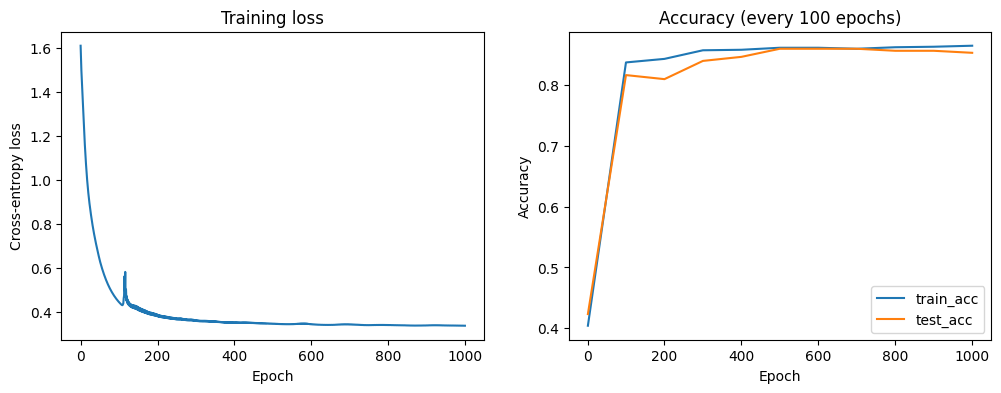

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss_history)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")


plt.subplot(1,2,2)

acc_epochs = []
for epoch in range(1, epochs+1):
    if epoch % 100 == 0 or epoch == 1:
        acc_epochs.append(epoch)

plt.plot(acc_epochs, train_acc_history, label='train_acc')
plt.plot(acc_epochs, test_acc_history, label='test_acc')

plt.title("Accuracy (every 100 epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Confusion Matrix:
 [[59  1  1  0  3]
 [ 2 44  0  2  3]
 [ 2  0 61  0  6]
 [ 0  1  2 47  3]
 [ 6  5  2  5 45]]
Class 0: Precision=0.855, Recall=0.922, F1=0.887
Class 1: Precision=0.863, Recall=0.863, F1=0.863
Class 2: Precision=0.924, Recall=0.884, F1=0.904
Class 3: Precision=0.870, Recall=0.887, F1=0.879
Class 4: Precision=0.750, Recall=0.714, F1=0.732

Macro Precision/Recall/F1: 0.8524860712840109 0.8539512472339078 0.8527757673646995
Micro Precision/Recall/F1: 0.8533333333333304 0.8533333333333304 0.8533333333328302


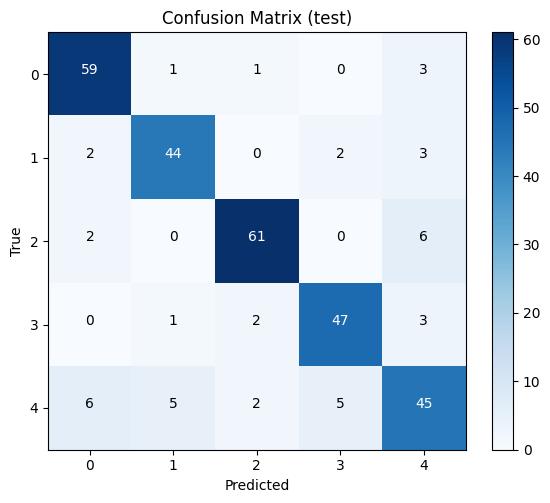

In [21]:
# metrics and confusion matrix
def confusion_matrix(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def precision_recall_f1(cm):
    # cm rows = true classes, cols = predicted classes
    TP = np.diag(cm).astype(float)
    FP = np.sum(cm, axis=0).astype(float) - TP
    FN = np.sum(cm, axis=1).astype(float) - TP
    TN = np.sum(cm).astype(float) - (TP + FP + FN)

    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    return precision, recall, f1

# predictions on test set
test_probs = nn.forward(X_test)
test_preds = np.argmax(test_probs, axis=1)

cm = confusion_matrix(Y_test, test_preds, n_classes)
precision, recall, f1 = precision_recall_f1(cm)

print("Confusion Matrix:\n", cm)
for i in range(n_classes):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

# macro and micro
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

# micro: compute totals
TP_sum = np.sum(np.diag(cm))
precision_micro = TP_sum / (np.sum(cm, axis=0).sum() + 1e-12)
recall_micro = TP_sum / (np.sum(cm, axis=1).sum() + 1e-12)
f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro + 1e-12)

print("\nMacro Precision/Recall/F1:", macro_precision, macro_recall, macro_f1)
print("Micro Precision/Recall/F1:", precision_micro, recall_micro, f1_micro)

# plot confusion matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (test)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted")
plt.ylabel("True")

# annotate
thresh = cm.max() / 2.
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


**Conclusion:**


1. We built a multi class neural network for data with five categories using softmax output and cross entropy loss. The model achieved solid accuracy and produced meaningful evaluation metrics such as confusion matrix, precision, recall, and F1-scores. These results show that the network can learn multi class patterns effectively.

2. During implementation, the main challenges were handling softmax gradients, managing one hot labels, and debugging shape mismatches in backpropagation. Working through these issues improved understanding of vectorized operations and multi layer gradient flow.

3. For future improvements, we could try adding regularization, using mini batch training, experimenting with deeper or wider architectures, tuning the learning rate, or applying better optimization. These changes may help the network converge faster and achieve higher accuracy on multi-classes.